## Введение в анализ данных, ИАД-2

## НИУ ВШЭ, 2019-20 учебный год

### Домашнее задание №2

Задание выполнил(а): _Соснин Артём_

### Общая информация

__Дата выдачи:__ 04.03.2019

__Дедлайн:__ 23:59 17.03.2019

### Оценивание и штрафы

Оценка за ДЗ вычисляется по следующей формуле:

$$
\text{points} \times 10 / \text{max points},
$$

где points — количество баллов, которое вы набрали, max_points - максимальное число баллов за задание. Бонусные задания отмечены звездочками (*)

За сдачу задания позже срока на итоговую оценку за задание накладывается штраф в размере 1 балл в день, но получить отрицательную оценку нельзя.

__Внимание!__ Домашнее задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов.

### Формат сдачи

Загрузка файлов с решениями происходит в системе [Anytask](https://anytask.org/).


# kNN своими руками (4)

Реализуйте взвешенный алгоритм kNN для регрессии. Пусть нам нужно вычислить значение $y$ для некоторого $x$ при известных данных $\left(x_1, y_1\right), \ldots, \left(x_\ell, y_\ell\right)$. Предсказанием вашего регрессора будет являться

$$
\hat{y} = \frac{\sum\limits_{i=1}^kw_iy_{(i)}}{\sum\limits_{i=1}^kw_i},
$$
где $\left(x_{(1)}, y_{(1)}\right), \ldots, \left(x_{(k)}, y_{(k)}\right)$ - ближайшие $k$ объектов к $x$ по некоторой метрике $d(\cdot, \cdot)$, а $w_i = \frac{1}{d\left(x, x_{(i)}\right)}$. Ваш алгоритм должен уметь работать с двумя метриками:

$$
d\left(x_{(i)}, x\right) = \|x_{(i)} - x\|_2 = \sqrt{\sum\limits_{j=1}^n\left(x_{(i)}^j - x^j\right)^2}\qquad\text{(евклидова)}
$$
$$
d\left(x_{(i)}, x\right) = \|x_{(i)} - x\|_1 = \sum\limits_{j=1}^n\left|x_{(i)}^j - x^j\right|\qquad\text{(манхэттена)}
$$

Сверьте для нескольких комбинаций различных параметров свой результат на искусственной выборке с результатом соответствующего алгоритма из `sklearn` по метрике качества MSE.

In [12]:
import numpy as np
from scipy.spatial import distance
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as LR, Lasso, Ridge

In [77]:
class KNN:
    def __init__(self, metric='euclid', k=5):
        """
        PARAMETERS:
        metric ('euclid' or 'manhattan')
        k - number of nearest neighbors
        """
        
        self.metric = metric
        self.k = k
        self.knn = None
        self.X_train = None
        self.y_train = None
        
    def fit(self, X_train, y_train):
        """
        INPUT:
        X_train - np.array of shape (l, d)
        y_train - np.array of shape (l,)
        """

        self.y_train = y_train
        self.X_train = X_train
        
        return self
        
    def predict(self, X_test):
        """
        INPUT:
        X_test - np.array of shape (m, d)
        
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        
        predictions = np.zeros(len(X_test))
        dists = distance.cdist(self.X_train, X_test, metric=self.metric)
        func = np.vectorize(lambda x : 1/x)
        weights = func(dists)
        k_nearest = np.argsort(weights, axis=0)[-self.k:,:].T
        for neighbours in range(len(k_nearest)):
            numerator = 0
            denominator = 0
            for idx in k_nearest[neighbours]:
                numerator += dists[idx][neighbours] * self.y_train[idx]
                denominator += dists[idx][neighbours]
            predictions[neighbours] = numerator/denominator
        return predictions

In [16]:
np.random.seed(17032019)
X_train = np.random.randn(1000, 50)
y_train = np.random.randn(1000,)
X_test = np.random.randn(500, 50)
y_test = np.random.randn(500,)

In [89]:
knn1 = KNN(k = 10)
knn1.fit(X_train, y_train)
y_pred1 = knn1.predict(X_test)

In [90]:
knn2 = KNeighborsRegressor(n_neighbors=10)
knn2.fit(X_train, y_train)
y_pred2 = knn2.predict(X_test)

In [91]:
print('MSE для KNN своими руками: ', mean_squared_error(y_test ,y_pred1))
print('MSE для KNN в sclearn: ', mean_squared_error(y_test ,y_pred2))

MSE для KNN своими руками:  1.0762400801615037
MSE для KNN в sclearn:  1.0756506817802374


# Линейная регрессия своими руками (4)

Реализуйте линейную регрессию с градиентным спуском для [функции потерь Хьюбера](https://en.wikipedia.org/wiki/Huber_loss):

$$
L_\delta\left(y, \hat{y}\right) =
\begin{cases}
\frac{1}{2}\left(y - \hat{y}\right)^2, \qquad &|y - \hat{y}| \leq \delta\\
\delta\left|y - \hat{y}\right| - \frac{1}{2}\delta^2,\qquad & \text{otherwise}
\end{cases}
$$

В таком случае общее значение функции потерь на всем датасете $(x_1, y_1), \ldots, (x_\ell, y_\ell)$ будет равно

$$
L = \frac{1}{\ell}\sum\limits_{i=1}^\ell L_\delta\left(y_i, \hat{y}_i\right)
$$

Проверьте работу вашего метода: выведите результаты его работы на той же искусственной выборке, что и в задаче выше (в качестве метрик качества используйте MSE и Huber loss). Постройте график зависимости значения функции потерь от итерации градиентного спуска.

*Вы можете опустить единичный признак в модели и не добавлять его в данные. Для данной искусственной выборки это не актуально, потому что целевая переменная в этом случае является случайной величиной из стандартного нормального распределения со средним 0.*

*Вектор весов в градиентном спуске можете инициализировать нулями.*

In [17]:
def euclid_metric(X, Y):
    return np.sqrt(np.sum((X-Y)**2))

In [35]:
def calc_L(y_train, y_pred, delta, X_train):
    return np.sum(np.where(abs(y_train - y_pred) <= delta, ((y_train - y_pred) ** 2) / 2, 
                                delta * abs((y_train - y_pred)) - 
                                (delta ** 2) / 2)) / len(X_train)

In [76]:
class LinearRegressionHuber:
    def __init__(self, delta=1.0, max_iter=1000, tol=1e-6, eta=1e-2):
        
        self.delta = delta
        self.max_iter = max_iter
        self.tol = tol
        self.eta = eta
        self.w = None
        self.loss_history = None
        self.grad = None
        
    def fit(self, X_train, y_train):
        
        self.grad = np.zeros_like(X_train)
        self.w = np.zeros(len(X_train[0]))
        y_pred = X_train.dot(self.w)
        L = calc_L(y_train, y_pred, self.delta, X_train)
        self.loss_history = [L]
        old_w = self.w.copy()
        matr = np.zeros_like(X_train)
        for i in range(len(X_train)):  
            if abs(y_train[i] - y_pred[i]) <= self.delta:
                 matr[i] = (-1)*X_train[i]*(y_train[i] - y_pred[i])
            else:
                if y_train[i] - y_pred[i] < 0:
                    matr[i] = self.delta*X_train[i]
                else:
                    matr[i] = -self.delta*X_train[i]
        self.w = (-1)*self.eta * (np.sum(matr, axis=0) / len(X_train))
        self.grad [0] = np.sum(matr, axis=0) / len(X_train)
        L = calc_L(y_train, y_pred, self.delta, X_train)
        y_pred = X_train.dot(self.w)
        self.loss_history.append(L) 
        counter = 0
        while euclid_metric(self.w, old_w) > self.tol and counter != self.max_iter-2: 
            counter += 1
            old_w = self.w.copy()
            matr = np.zeros_like(X_train)
            for i in range(len(X_train)):
                if abs(y_train[i] - y_pred[i]) <= self.delta:
                    matr[i] = (-1)*X_train[i]*(y_train[i] - y_pred[i])  
                else:
                    if y_train[i] - y_pred[i] < 0:
                        matr[i] = self.delta*X_train[i]
                    else:
                        matr[i] = -self.delta*X_train[i]
            self.w = old_w - self.eta * (np.sum(matr, axis=0) / len(X_train))
            self.grad[counter] = np.sum(matr, axis=0) / len(X_train) 
            L = calc_L(y_train, y_pred, self.delta, X_train)
            y_pred = X_train.dot(self.w)
            self.loss_history.append(L) 
            
        return self.loss_history
        
    def predict(self, X_test):
        
        y_pred = X_test.dot(self.w)
        
        return y_pred
    
    def calc_gradient(self, X, y):
        
        grad = self.grad[self.max_iter//2]
        
        return grad
    
    def calc_loss(self, X, y):
        
        loss = np.array(self.loss_history).mean()
        
        return loss

In [68]:
k = LinearRegressionHuber()
Loss = k.fit(X_train, y_train)

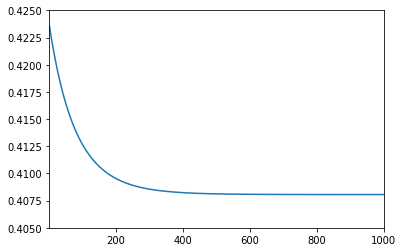

In [75]:
plt.plot(np.linspace(1, 1000, 1000), Loss)
plt.xlim([1, 1000])
plt.ylim([0.405, 0.425])
plt.show()

In [77]:
pred = LR().fit(X_train, y_train)
y_pred3 = k.predict(X_test)
y_pred4 = pred.predict(X_test)

In [79]:
print('MSE для LR своими руками: ', mean_squared_error(y_test ,y3_pred))
print('MSE для LR в sclearn: ', mean_squared_error(y_test ,y4_pred))

MSE для LR своими руками:  1.0919500874768941
MSE для LR в sclearn:  1.0882539618811702


In [29]:
print('Calc_loss: ', k.calc_loss(X_train, y_train))

Calc_loss:  0.44820206194528317


In [30]:
print('Градиент:', k.calc_gradient(X_train, y_train))

Grad: [-1.04372600e-03 -7.68346999e-04  1.20685826e-04  2.53619880e-04
 -1.28547571e-03 -1.00743912e-03  1.51932981e-05 -2.07574304e-04
 -1.85004980e-03  7.43381059e-04  2.65183035e-04  3.47228053e-03
  9.88670024e-04  1.93563038e-04  1.67045684e-03 -8.23286604e-04
 -2.04204365e-03  1.10503290e-03 -1.84128161e-04  1.93667425e-04
 -2.39991769e-03  4.02876738e-04  1.05532003e-03 -1.24019299e-03
  1.30454360e-03 -2.23752066e-05 -5.55721235e-04  7.47098830e-04
  2.92661126e-04  1.92494738e-04  2.94676789e-04  1.42945726e-04
 -2.84767372e-04  6.03252248e-04  1.82991231e-03  1.13040990e-03
  5.37049695e-04 -1.20690399e-03 -2.76294525e-04 -6.29036492e-04
 -1.86094443e-03  3.52424067e-04 -1.31345253e-03  1.00918709e-03
  2.55335330e-04 -5.97143597e-04 -2.26223099e-04 -2.07235370e-03
  4.46843190e-04  1.40222945e-03]


# Практика

Пожалуйста, при использовании различных функций из библиотек импортируйте все, что вам понадобилось в данной части, в следующем блоке:

In [135]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, f_regression
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures

%matplotlib inline

В этом домашнем задании вы поработаете с данными из другого соревнования на Kaggle: https://www.kaggle.com/c/house-prices-advanced-regression-techniques. Задача - предсказание цены дома.

In [136]:
data = pd.read_csv('train.csv', header=0)

In [137]:
data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [138]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [139]:
data.drop('Id', axis=1, inplace=True)

In [140]:
data.shape

(1460, 80)

## 1 (1)

Есть ли в данных пропуски? Если да, то для каждого столбца, в котором они имеются, посчитайте их количество и их долю от общего числа значений. Что вы наблюдаете?

In [141]:
data.isnull().any().any()

True

Количество пропусков по столбцам в порядке убывания:

In [142]:
mis_val = data.isnull().sum().sort_values(ascending = False)
mis_val.head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageCond        81
GarageFinish      81
GarageQual        81
GarageYrBlt       81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
RoofMatl           0
dtype: int64

Доля пропусков от общего числа значений:

In [143]:
(mis_val / len(data) * 100).head(20)

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageCond       5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageYrBlt      5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
RoofMatl         0.000000
dtype: float64

В некотрых столбцах почти все данные пропущены, например в: PoolQC, MiscFeature, Alley и Fence

## 2 (1)

Избавьтесь от пропусков. Для каждого из примененных методов обоснуйте свое решение. **Проверьте, что вы действительно избавились от пропусков.**

*Напоминание. В зависимости от типа столбца, можно заполнить пропуски, например, средним арифметическим, медианой, модой, можно какими-то отдельными значениями. А можно такие столбцы вообще удалить.*

Удалим столбцы с очень большим количеством пропусков, это - PoolQC, MiscFeature, Alley и Fence.

In [144]:
data = data.drop(['PoolQC','MiscFeature','Alley','Fence'], axis=1)

In [145]:
data.shape

(1460, 76)

Удалим строки с большим количеством пропусков:

In [146]:
data.isnull().sum(axis=1).sort_values(ascending = False)

520     11
705     11
533     11
1218    11
1011    11
39      11
1179    10
375      7
1030     7
392      7
1407     7
342      7
307      7
1143     7
287      7
1035     7
1321     7
1009     6
736      6
1234     6
1232     6
954      6
241      6
649      6
646      6
125      6
921      6
1219     6
1323     6
710      6
        ..
1130     0
482      0
481      0
480      0
478      0
477      0
476      0
1133     0
1115     0
503      0
504      0
506      0
527      0
525      0
524      0
523      0
522      0
521      0
1105     0
519      0
1106     0
517      0
1107     0
515      0
1109     0
511      0
510      0
1111     0
508      0
1162     0
Length: 1460, dtype: int64

In [147]:
data.index[data.isnull().any(axis=1)]

Int64Index([   0,    5,    7,   10,   12,   14,   15,   16,   17,   18,
            ...
            1445, 1446, 1448, 1449, 1450, 1452, 1453, 1454, 1458, 1459],
           dtype='int64', length=877)

In [148]:
for row in data.index[data.isnull().any(axis=1)]:
     if data.loc[row].isnull().sum() >= 5:
             data.drop(row, 0, inplace=True)
data.shape

(1349, 76)

In [149]:
data.isnull().sum().sort_values(ascending = False)

FireplaceQu      596
LotFrontage      246
MasVnrType         8
MasVnrArea         8
BsmtFinType2       1
Electrical         1
BsmtExposure       1
SalePrice          0
ExterQual          0
RoofMatl           0
Exterior1st        0
Exterior2nd        0
BsmtQual           0
ExterCond          0
Foundation         0
BsmtCond           0
BsmtFinType1       0
BsmtFinSF1         0
BsmtFinSF2         0
RoofStyle          0
YearRemodAdd       0
TotalBsmtSF        0
YearBuilt          0
MSZoning           0
LotArea            0
Street             0
LotShape           0
LandContour        0
Utilities          0
LotConfig          0
                ... 
PavedDrive         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
SaleType           0
GarageFinish       0
GarageYrBlt        0
GarageType         0
BsmtHalfBath       0
CentralAir         0
1stFlrSF     

FireplaceQu имеет NaN, если в доме нет камина, поэтому вместо пропусков впишем no.

In [150]:
data.loc[data['FireplaceQu'].isnull(), 'FireplaceQu'] = 'No'

LotFrontage - это длина улицы, соедененная с домом. Поэтому в эти пропуски можем вписать среднее значение.

In [151]:
data.loc[data['LotFrontage'].isnull(), 'LotFrontage'] = round(data['LotFrontage'].mean())

In [152]:
data.isnull().sum().sort_values(ascending = False).head(7)

MasVnrType      8
MasVnrArea      8
Electrical      1
BsmtFinType2    1
BsmtExposure    1
SalePrice       0
ExterCond       0
dtype: int64

In [153]:
data.groupby('MasVnrType').size()

MasVnrType
BrkCmn      15
BrkFace    434
None       764
Stone      128
dtype: int64

В пропуски для MasVnrType впишем None. А в MasVnrArea среднее значение для этого признака.

In [154]:
data.loc[data['MasVnrType'].isnull(), 'MasVnrType'] = 'None'
data.loc[data['MasVnrArea'].isnull(), 'MasVnrArea'] = round(data['MasVnrArea'].mean())

В остальные пропуски впишем самые популярные значения для соответствующих пропусков.

In [155]:
data.groupby('Electrical').size()

Electrical
FuseA      76
FuseF      17
FuseP       2
Mix         1
SBrkr    1252
dtype: int64

In [156]:
data.loc[data['Electrical'].isnull(), 'Electrical'] = 'SBrkr'

In [157]:
data.groupby('BsmtFinType2').size()

BsmtFinType2
ALQ      19
BLQ      32
GLQ      12
LwQ      46
Rec      53
Unf    1186
dtype: int64

In [158]:
data.loc[data['BsmtFinType2'].isnull(), 'BsmtFinType2'] = 'Unf'

In [159]:
data.groupby('BsmtExposure').size()

BsmtExposure
Av    213
Gd    128
Mn    111
No    896
dtype: int64

In [160]:
data.loc[data['BsmtExposure'].isnull(), 'BsmtExposure'] = 'No'

In [161]:
data.isnull().any().any()

False

Пропуссков не осталось

## 3 (1)

Обработайте категориальные признаки. В их обнаружении вам может помочь синтаксис `pandas` (например, можно обратить внимание на типы столбцов), а также описание датасета и его исследование. Объясните выбор метода (one-hot-encoding, label encoding, ...)

In [162]:
data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF'

one-hot-encoding более подходящий метод, потому что knn и линеная регрессия используют метрику между объектами. А при label encoding поучается, что мы из одного значения категориального признака вычитаем (прибавляем) другое.

In [163]:
data = pd.get_dummies(data, columns=['MSZoning', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType',
       'SaleCondition'], drop_first=True)
data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,0,1,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,0,1,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,0,1,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,0,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,0,1,0,0,0,1,0


## 4 (0.5)

Вычислите и визуализируйте попарную корреляцию Пирсона между всеми признаками. Какие выводы можно сделать?

*Для визуализации можно использовать `seaborn.heatmap()`.*

In [164]:
dcorr = data.iloc[:,:34].corr()
dcorr

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
MSSubClass,1.000000,-0.360415,-0.135947,0.048354,-0.095558,0.055693,0.038028,0.030346,-0.070532,-0.080376,...,0.080948,0.004504,-0.072267,-0.009566,-0.000793,-0.024113,-0.041122,-0.022291,0.010273,-0.021341
LotFrontage,-0.360415,1.000000,0.301772,0.226723,-0.042488,0.103552,0.077748,0.176123,0.220801,0.041675,...,0.064286,0.269645,0.332923,0.071801,0.145913,0.014154,0.064564,0.031419,0.185375,0.000487
LotArea,-0.135947,0.301772,1.000000,0.089923,-0.002274,-0.006434,0.000296,0.096566,0.210654,0.109643,...,-0.026376,0.138179,0.167822,0.166350,0.083399,-0.013040,0.019162,0.038104,0.076822,0.040654
OverallQual,0.048354,0.226723,0.089923,1.000000,-0.163995,0.571045,0.549813,0.400306,0.201683,-0.084029,...,0.546382,0.593238,0.532690,0.215901,0.312894,-0.118158,0.025694,0.043490,0.063842,-0.029645
OverallCond,-0.095558,-0.042488,-0.002274,-0.163995,1.000000,-0.416762,0.032668,-0.140784,-0.064234,0.035839,...,-0.337302,-0.250740,-0.204892,-0.011229,-0.061393,0.066920,0.024326,0.055036,-0.003160,0.077500
YearBuilt,0.055693,0.103552,-0.006434,0.571045,-0.416762,1.000000,0.620046,0.298353,0.223278,-0.069946,...,0.826574,0.524512,0.443831,0.209509,0.219202,-0.386288,0.027974,-0.072587,0.000468,-0.033977
YearRemodAdd,0.038028,0.077748,0.000296,0.549813,0.032668,0.620046,1.000000,0.167950,0.099779,-0.084758,...,0.644184,0.460279,0.386590,0.198572,0.232987,-0.220494,0.038504,-0.054178,0.002871,-0.001931
MasVnrArea,0.030346,0.176123,0.096566,0.400306,-0.140784,0.298353,0.167950,1.000000,0.252740,-0.081002,...,0.248935,0.364081,0.367611,0.148162,0.127915,-0.111909,0.015162,0.052310,0.009299,-0.028995
BsmtFinSF1,-0.070532,0.220801,0.210654,0.201683,-0.064234,0.223278,0.099779,0.252740,1.000000,-0.062164,...,0.144899,0.200556,0.287357,0.184719,0.110703,-0.101767,0.026269,0.050673,0.141620,0.007552
BsmtFinSF2,-0.080376,0.041675,0.109643,-0.084029,0.035839,-0.069946,-0.084758,-0.081002,-0.062164,1.000000,...,-0.092121,-0.077209,-0.049638,0.059791,0.001485,0.044747,-0.031352,0.085674,0.041051,0.006252


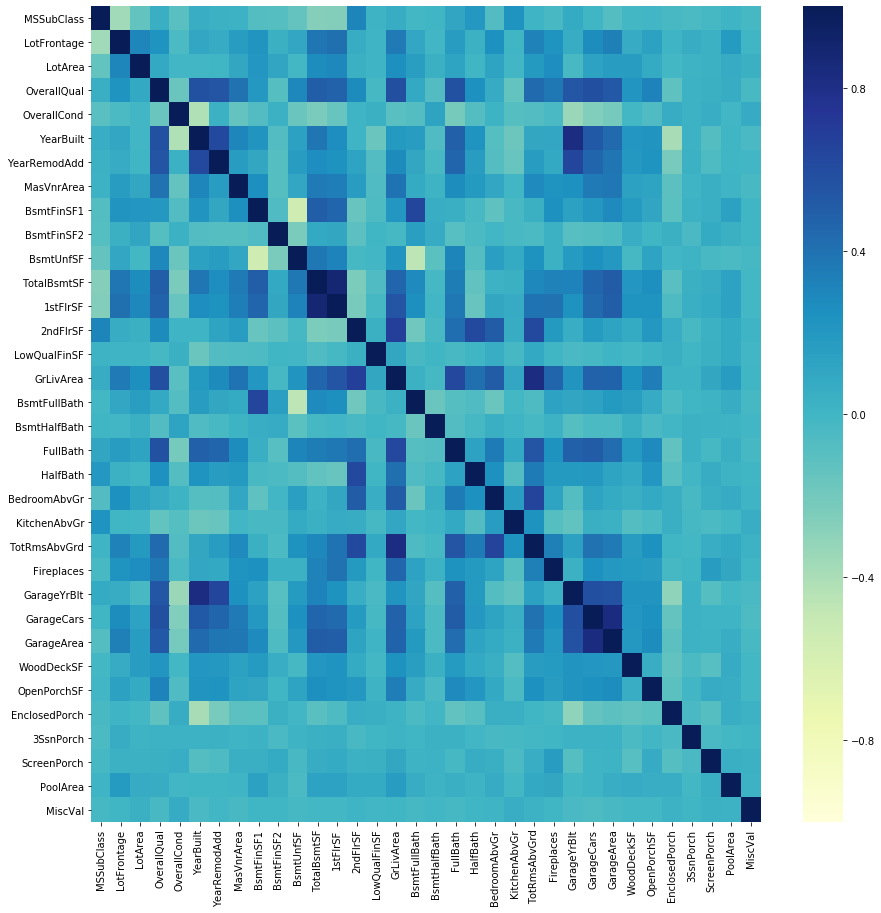

In [165]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(dcorr, vmin=-1, vmax=1, cmap="YlGnBu", ax=ax)
plt.show()

Из графика видно, что между собой сильно коррелируют GarageYrBlt и YearBuilt, то есть дата строительства всего комплекса с домом и год постройки гаража. 
А также 1stFlrSF и TotalBsmtSF: площадь первого этажа и общая подвальная площадь.
Видна корреляция между GarageArea и GarageCars: площадью гаража и количеством вмещаемых в гараж автомобилей.
и т.д.

## 5 (0.5)

Найдите признаки с максимальным и минимальным **абсолютным** значением коэффициента корреляции Пирсона с предсказываемым значением. Изобразите на графиках зависимость найденных признаков от предсказываемого значения.

*Не забудьте указать название графика и обозначить, что изображено по каждой из осей.*

In [166]:
abs(data.corr()['SalePrice']).nlargest(2)

SalePrice      1.000000
OverallQual    0.784687
Name: SalePrice, dtype: float64

In [167]:
abs(data.corr()['SalePrice']).nsmallest(2)

RoofStyle_Mansard    0.000320
Foundation_Wood      0.000868
Name: SalePrice, dtype: float64

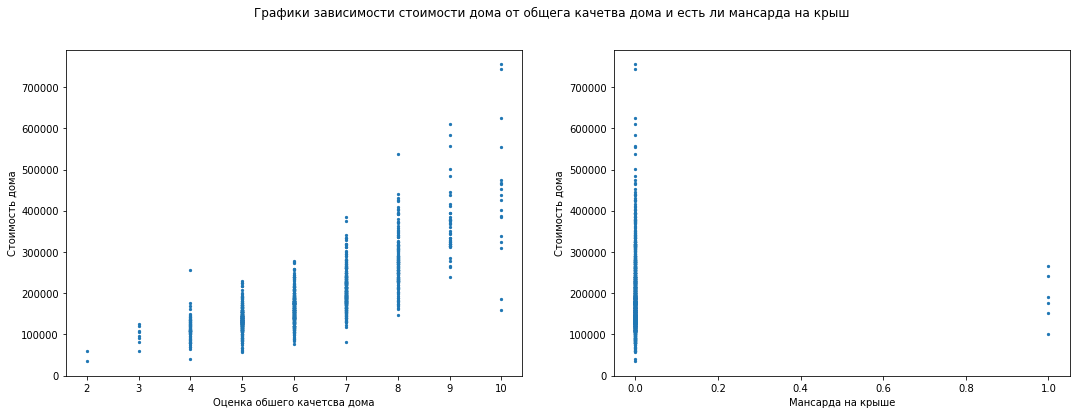

In [169]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

ax = axs[0]
ax.scatter(data['OverallQual'], data['SalePrice'], s = 5)
ax.set_xlabel('Оценка обшего качетсва дома')
ax.set_ylabel('Стоимость дома')

ax = axs[1]
ax.scatter(data['RoofStyle_Mansard'], data['SalePrice'], s = 5)
ax.set_xlabel('Мансарда на крыше')
ax.set_ylabel('Стоимость дома')

fig.suptitle('Графики зависимости стоимости дома от общега качетва дома и есть ли мансарда на крыш')

plt.show()

## 6 (0.5)

Постройте гистограмму распределения предсказываемого значения. Для избавления от разницы в масштабах, а также «смещения» распределения переменной в сторону нормального (что бывает полезно при статистическом анализе), можно прологарифмировать ее (это обратимое преобразование, поэтому целевую переменную легко восстановить). В данном случае воспользуйтесь `numpy.log1p`, чтобы сделать преобразование $y \to \ln\left(1 + y\right)$. Постройте гистограмму распределения от нового предсказываемого значения. Опишите наблюдения.

*В дальнейшем используйте в качестве предсказываемого значения вектор, который получился после логарифмирования.*

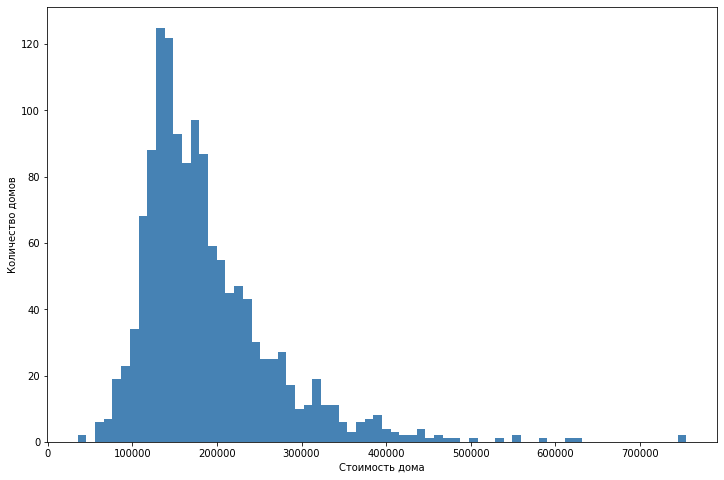

In [170]:
plt.figure(figsize=(12,8))
plt.hist(data['SalePrice'], histtype='stepfilled', color='steelblue', bins= 70)
plt.xlabel('Стоимость дома')
plt.ylabel('Количество домов')
plt.show()

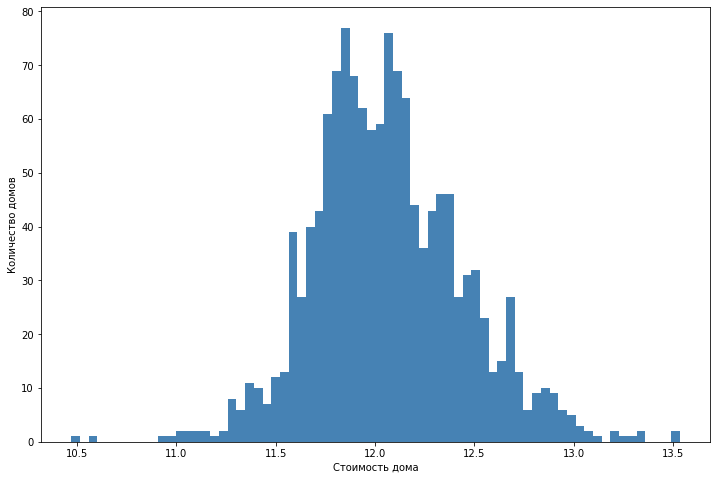

In [171]:
pred = np.log1p(data['SalePrice'])
plt.figure(figsize=(12,8))
plt.hist(pred, histtype='stepfilled', color='steelblue', bins= 70)
plt.xlabel('Стоимость дома')
plt.ylabel('Количество домов')
plt.show()

График распределения стал похож на нормальный.

Перейдем непосредственно к построению моделей. Разобьем выборку на обучение и контроль.

*Пожалуйста, **не меняйте** значение `random_state` в следующей ячейке.*

In [175]:
y = data['SalePrice']
X = data.drop('SalePrice', axis=1)

In [176]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=17032019)

In [177]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1011, 232), (338, 232), (1011,), (338,))

## 7 (2)

Примените к данным следующие алгоритмы:

- kNN
- линейная регрессия
- Lasso
- Ridge

Для каждого из методов подберите гиперпараметры с помощью кросс-валидации. Обучите алгоритмы с лучшими гиперпараметрами на обучающей выборке и оцените качество по метрике **Root** Mean Squared Error. Какой из методов показывает себя лучше?

In [ ]:
# your code here

## 8 (1)

Постройте гистограммы значений весов для линейной регрессии, Lasso и Ridge. Опишите наблюдения. В чем различия между полученными наборами весов и почему?

In [ ]:
# your code here

## 9 (0.5)

Добейтесь того, чтобы в заданиях выше ваш лучший алгоритм давал качество не больше 0.125 на тестовых данных по метрике RMSE (если вы дошли до этого задания, а качество выше уже удовлетворяет этому условию, вы автоматически получите за него полный балл).

## 10* (0.5)

Добейтесь того, чтобы в заданиях выше ваш лучший алгоритм давал качество не больше 0.121 на тестовых данных по метрике RMSE. Для этого вы можете использовать самые разные методы, какие захотите - отбор признаков, генерация новых, разные способы предобработки данных. Единственное ограничение - не использовать никакие алгоритмы регрессии, кроме kNN, линейной регрессии, Lasso и Ridge.

In [ ]:
# your code here

# Теория

За данную часть можно получить бонусные баллы. Решения необходимо оформить в этом же файле в ячейках типа Markdown, пользуясь $\LaTeX$ для записи математических формул.

## 1* (0.5)

Найдите константу $C$, решающую следующую задачу ($0 < \tau < 1$ фиксировано):

$$
\sum\limits_{i=1}^\ell\rho_\tau\left(y_i - C\right) \to \min_C,
$$

где

$$
\rho_\tau(z) =
\begin{cases}
\tau z, & z > 0\\
(\tau - 1)z, & z \leq 0
\end{cases}
$$

*(your solution here)*